In [33]:
import re
import string
import emoji
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

### Data Labelling

In [2]:
def assign_category(title: str) -> str:
    title_lower = title.lower()
    # Rule for body work
    if any(kw in title_lower for kw in ['massage', 'bodywork', 'spa', 'therapeutic', 'body work', 'masseur']):
        return 'body-work'
    # Rule for hair-styling
    elif any(kw in title_lower for kw in ['haircut', 'braid', 'barber', 'hair', 'stylist']):
        return 'hair-styling'
    # Rule for health-aid
    elif any(kw in title_lower for kw in ['caregiver', 'health aide', 'nurse', 'home care', 'medical']):
        return 'health-aid'
    # Rule for fitness
    elif any(kw in title_lower for kw in ['trainer', 'fitness', 'workout', 'yoga', 'calisthenics']):
        return 'fitness'
    # Default to others
    else:
        return 'others'

# Load CSV after removing potential comment/header lines if necessary.
# df = pd.read_csv(r'd:\Projects\AI\Bots\NLP Project\craigslist_scraper\craigslist_titles.csv')
# df['category'] = df['title'].apply(assign_category)

# # Save the labeled data to a new CSV file
# df.to_csv(r'd:\Projects\AI\Bots\NLP Project\craigslist_scraper\craigslist_titles_labeled.csv', index=False)

### Exploratory Data Analysis

In [15]:
# Load your labeled CSV file (adjust path if needed)
df = pd.read_csv(r'd:\Projects\AI\Bots\NLP Project\craigslist_scraper\craigslist_titles_labeled.csv')

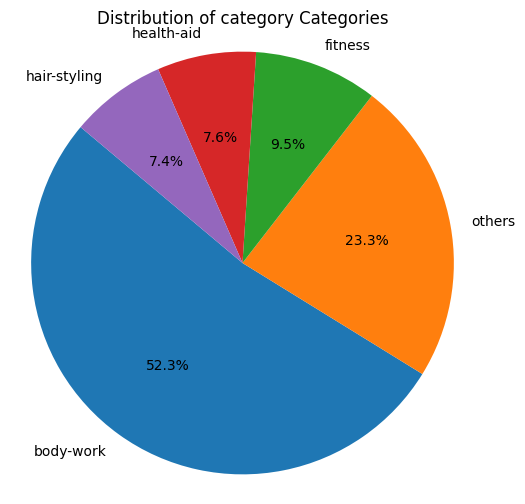

In [17]:
def plot_category_distribution(df, column='category'):
    """
    Plots a pie chart showing the percentage distribution of each unique category in the specified column.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        column (str): The column name which contains the category information.
    """
    import matplotlib.pyplot as plt
    
    # Get category counts
    counts = df[column].value_counts()
    
    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of {column} Categories')
    plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
    plt.show()

plot_category_distribution(df, column='category')

### Data Preprocessing

In [3]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aashrith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aashrith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Aashrith\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Data Cleaning

In [5]:
def clean_text(text: str) -> str:
    """
    Remove links, emojis, punctuation, numbers, and extra whitespace.
    """
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#### Converting categorical data into numerical

In [6]:
def lemmatize_text(text: str) -> str:
    """
    Tokenize the text, remove stopwords, and perform lemmatization.
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

In [7]:
def preprocess_text(text: str) -> str:
    """
    Combines cleaning and lemmatization steps.
    """
    cleaned = clean_text(text)
    lemmatized = lemmatize_text(cleaned)
    return lemmatized

### Preparing the data for model fitting

In [8]:
def prepare_train_test(df: pd.DataFrame, text_column: str, label_column: str, 
                       test_size: float = 0.2, random_state: int = 42):
    """
    Preprocess the text column using TF-IDF and convert categorical labels into codes.
    Splits the dataset into training and test sets.
    Returns X_train, X_test, y_train, y_test and the tfidf vectorizer.
    """
    # Create a new column with preprocessed text
    df['clean_' + text_column] = df[text_column].apply(preprocess_text)
    
    # Generate TF-IDF embeddings with ngram range (1,2)
    tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=2)
    X = tfidf.fit_transform(df['clean_' + text_column])
    
    # Convert labels to numeric codes
    df['label'] = pd.Categorical(df[label_column]).codes
    y = df['label']

    category_names = list(pd.Categorical(df[label_column]).categories)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state)
    return X_train, X_test, y_train, y_test, tfidf, category_names

In [ ]:
# Prepare the train/test split from the "title" column and "category" as label
X_train, X_test, y_train, y_test, tfidf, target_names = prepare_train_test(df, text_column='title', 
                                                               label_column='category')

### Fitting and evaluating different models

In [18]:
def fit_model(X_train, y_train, model_type: str = 'logistic'):
    """
    Fits a ML model based on the type provided.
    Currently supports 'logistic'.
    """
    if model_type == 'logistic':
        model = LogisticRegression(max_iter=1000, random_state=42)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(random_state=42)
    elif model_type == 'xgboost':
        
        model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    else:
        raise ValueError("Unsupported model type. Choose 'logistic', 'random_forest', or 'xgboost'.")
    
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test, target_names):
    """
    Uses the fitted model to predict on the test set and prints the evaluation metrics.
    Returns the predicted labels.
    """
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print("Confusion Matrix:")
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Accuracy: {acc:.4f}, Weighted F1 Score: {f1:.4f}")
    return y_pred, acc, f1

#### Logistic Regression

Classification Report:
              precision    recall  f1-score   support

   body-work       0.88      1.00      0.93       201
     fitness       0.94      0.82      0.87        38
hair-styling       1.00      0.58      0.73        26
  health-aid       1.00      0.33      0.50        24
      others       0.83      0.88      0.86        91

    accuracy                           0.88       380
   macro avg       0.93      0.72      0.78       380
weighted avg       0.89      0.88      0.87       380

Confusion Matrix:


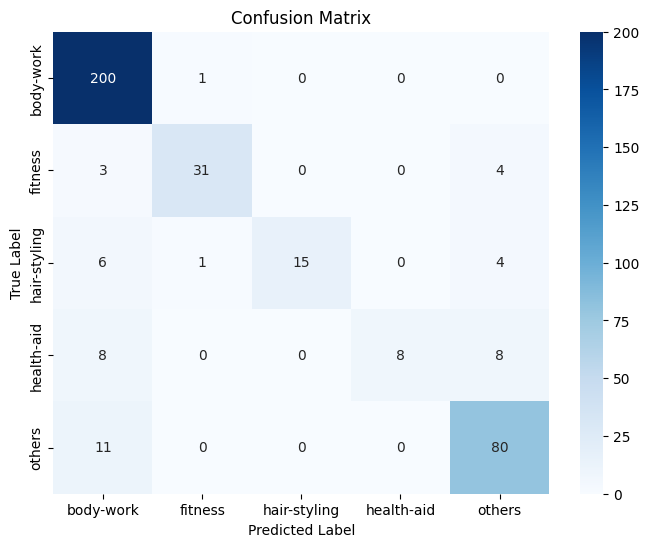

Accuracy: 0.8789, Weighted F1 Score: 0.8671
Classification Report:
              precision    recall  f1-score   support

   body-work       0.80      1.00      0.89        48
     fitness       1.00      1.00      1.00         7
hair-styling       1.00      0.11      0.20         9
  health-aid       1.00      0.42      0.59        12
      others       0.61      0.70      0.65        20

    accuracy                           0.78        96
   macro avg       0.88      0.65      0.67        96
weighted avg       0.82      0.78      0.75        96

Confusion Matrix:


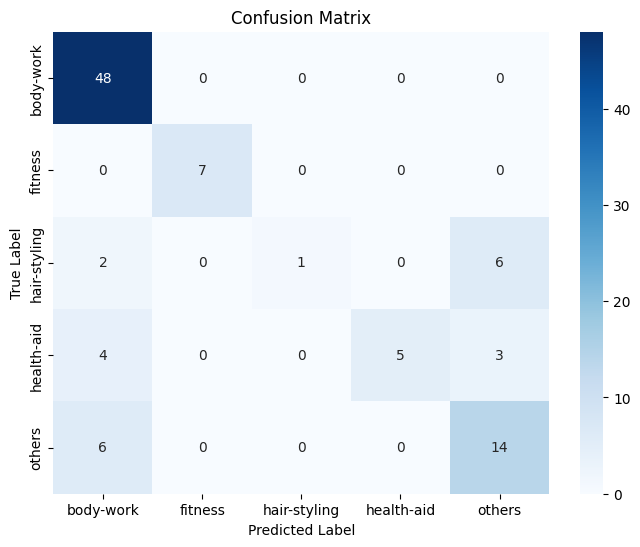

Accuracy: 0.7812, Weighted F1 Score: 0.7453


In [22]:
# Fit the Logistic Regression model
lr_model = fit_model(X_train, y_train, model_type='logistic')

# Evaluate the model performance
lr_y_train_pred, lr_train_acc, lr_train_f1 = evaluate_model(lr_model, X_train, y_train, target_names)
lr_y_test_pred, lr_test_acc, lr_test_f1 = evaluate_model(lr_model, X_test, y_test, target_names)

#### Random Forest

Classification Report:
              precision    recall  f1-score   support

   body-work       0.99      0.99      0.99       201
     fitness       1.00      0.95      0.97        38
hair-styling       0.91      0.81      0.86        26
  health-aid       0.96      1.00      0.98        24
      others       0.92      0.97      0.94        91

    accuracy                           0.97       380
   macro avg       0.96      0.94      0.95       380
weighted avg       0.97      0.97      0.97       380

Confusion Matrix:


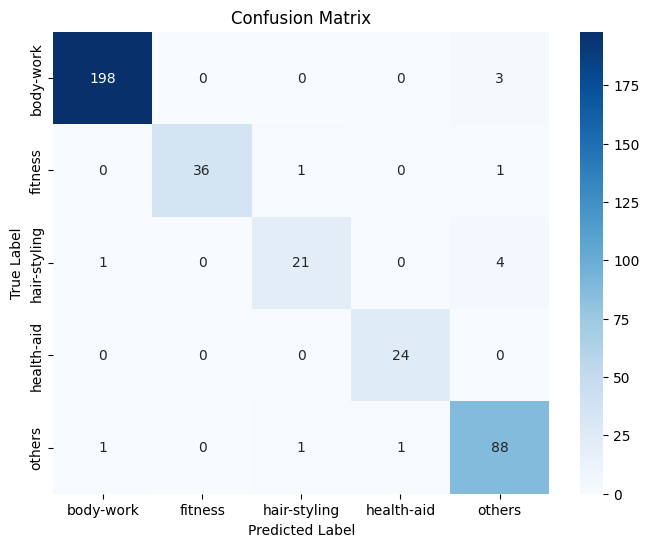

Accuracy: 0.9658, Weighted F1 Score: 0.9656
Classification Report:
              precision    recall  f1-score   support

   body-work       0.92      1.00      0.96        48
     fitness       1.00      1.00      1.00         7
hair-styling       1.00      0.44      0.62         9
  health-aid       0.71      0.42      0.53        12
      others       0.62      0.80      0.70        20

    accuracy                           0.83        96
   macro avg       0.85      0.73      0.76        96
weighted avg       0.85      0.83      0.82        96

Confusion Matrix:


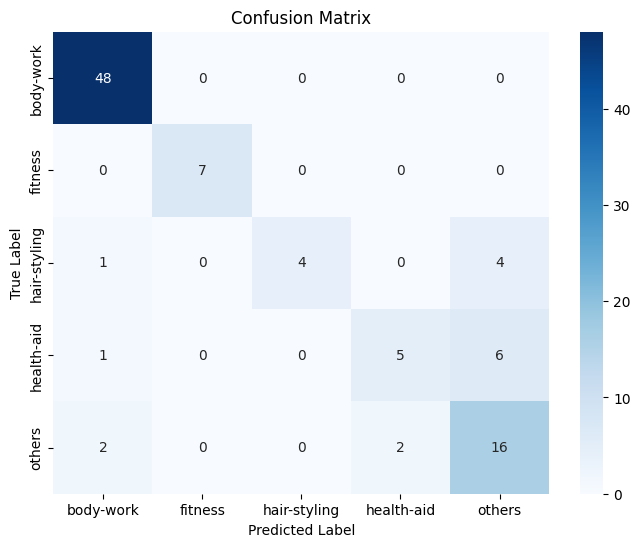

Accuracy: 0.8333, Weighted F1 Score: 0.8213


In [24]:
# Fit the Random Forest model
rf_model = fit_model(X_train, y_train, model_type='random_forest')

# Evaluate the model performance
rf_y_train_pred, rf_train_acc, rf_train_f1 = evaluate_model(rf_model, X_train, y_train, target_names)
rf_y_test_pred, rf_test_acc, rf_test_f1 = evaluate_model(rf_model, X_test, y_test, target_names)

#### XgBoost

c:\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:30:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

   body-work       0.98      0.97      0.97       201
     fitness       0.97      0.84      0.90        38
hair-styling       0.95      0.73      0.83        26
  health-aid       0.89      0.71      0.79        24
      others       0.77      0.95      0.85        91

    accuracy                           0.92       380
   macro avg       0.91      0.84      0.87       380
weighted avg       0.92      0.92      0.92       380

Confusion Matrix:


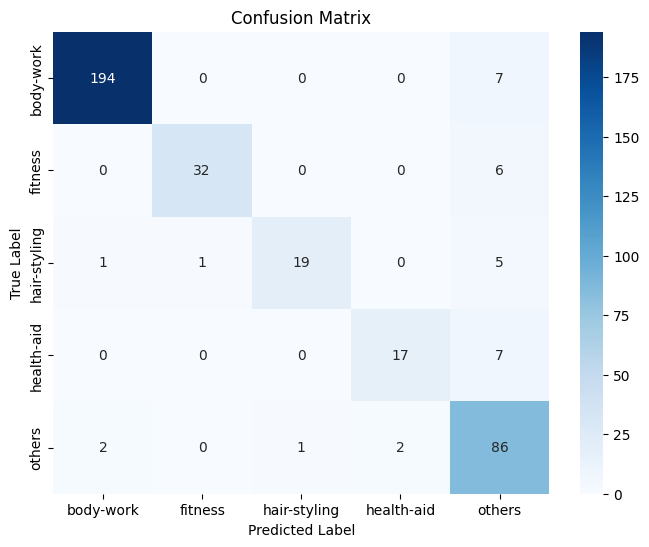

Accuracy: 0.9158, Weighted F1 Score: 0.9162
Classification Report:
              precision    recall  f1-score   support

   body-work       0.92      1.00      0.96        48
     fitness       1.00      1.00      1.00         7
hair-styling       1.00      0.44      0.62         9
  health-aid       0.86      0.50      0.63        12
      others       0.65      0.85      0.74        20

    accuracy                           0.85        96
   macro avg       0.89      0.76      0.79        96
weighted avg       0.87      0.85      0.84        96

Confusion Matrix:


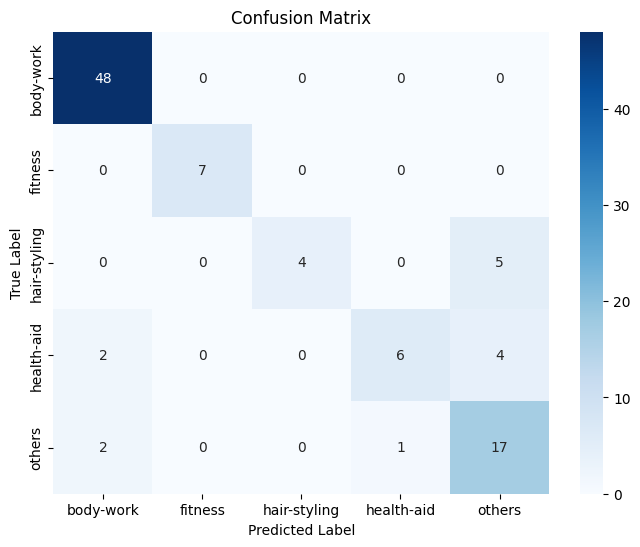

Accuracy: 0.8542, Weighted F1 Score: 0.8435


In [25]:
# Fit the Xgboost model
xgb_model = fit_model(X_train, y_train, model_type='xgboost')

# Evaluate the model performance
xgb_y_train_pred, xgb_train_acc, xbg_train_f1 = evaluate_model(xgb_model, X_train, y_train, target_names)
xbg_y_test_pred, xgb_test_acc, xgb_test_f1 = evaluate_model(xgb_model, X_test, y_test, target_names)

### Compare model performances

In [37]:
model_results = {"Logistic Regression": (lr_test_acc*100, lr_test_f1*100),
                 "Random Forest": (rf_test_acc*100, rf_test_f1*100),
                 "XGBoost": (xgb_test_acc*100, xgb_test_f1*100)}

models_names = list(model_results.keys())
models = [lr_model, rf_model, xgb_model]

In [40]:
def compare_model_performance(models_results):
    """
    Plots two separate bar plots for accuracies and F1 scores of different models.
    
    Parameters:
      models_results: Dictionary where keys are model names and values are tuples/lists:
                      (accuracy, f1_score)
    """
    model_names = list(models_results.keys())
    accuracies = [models_results[name][0] for name in model_names]
    f1_scores = [models_results[name][1] for name in model_names]
    
    # Bar plot for Accuracy
    plt.figure(figsize=(8,6))
    ax = sns.barplot(x=model_names, y=accuracies, palette="Blues_d")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracies")
    plt.ylim(0,100)
    for bar in ax.patches:
        ax.annotate(f'{bar.get_height():.2f}', 
                    (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                    ha='center', va='bottom', color='black')
    plt.show()
    
    # Bar plot for F1 Score
    plt.figure(figsize=(8,6))
    ax2 = sns.barplot(x=model_names, y=f1_scores, palette="Greens_d")
    plt.ylabel("Weighted F1 Score")
    plt.title("Model F1 Scores")
    plt.ylim(0,100)
    for bar in ax2.patches:
        ax2.annotate(f'{bar.get_height():.2f}', 
                     (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                     ha='center', va='bottom', color='black')
    
    plt.tight_layout()
    plt.show()

C:\Users\Aashrith\AppData\Local\Temp\ipykernel_31512\1117373027.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=model_names, y=accuracies, palette="Blues_d")


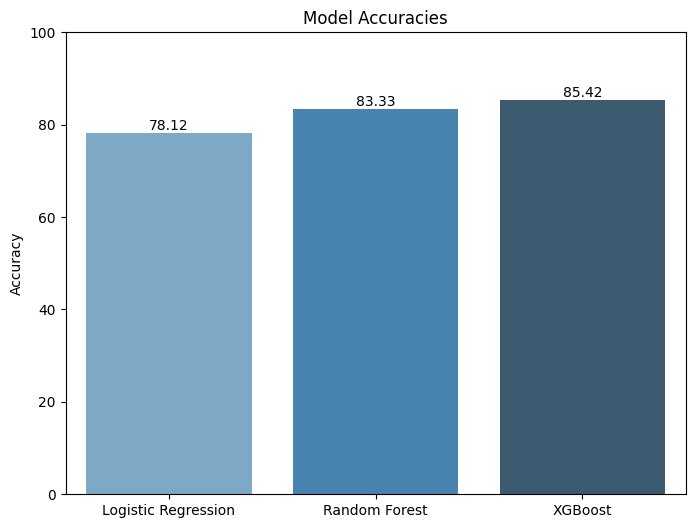

C:\Users\Aashrith\AppData\Local\Temp\ipykernel_31512\1117373027.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=model_names, y=f1_scores, palette="Greens_d")


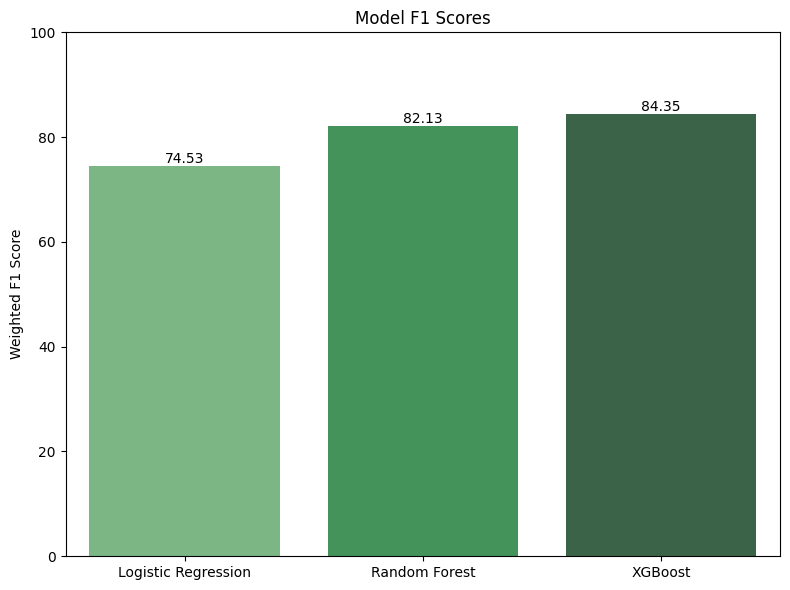

In [41]:
compare_model_performance(model_results)

In [31]:
def plot_roc_curves(models, model_names, X_test, y_test, colors=None):
    """
    Plots ROC curves for multiple models. For multi-class,
    a micro-average ROC curve is computed.
    
    Parameters:
      models: List of trained models supporting predict_proba.
      model_names: List of names corresponding to the models.
      X_test: Test features.
      y_test: True labels.
      colors: Optional list of colors for each model. If None, a default list will be used.
    """
    from itertools import cycle
    # Binarize the true labels for multi-class ROC
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = y_test_bin.shape[1]
    
    if colors is None:
        colors = cycle(['darkorange', 'green', 'blue'])
    
    plt.figure(figsize=(8,6))
    for model, name, color in zip(models, model_names, colors):
        # Get probability scores for each class
        y_score = model.predict_proba(X_test)
        # Compute micro-average ROC curve and area
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Micro-average)')
    plt.legend(loc="lower right")
    plt.show()

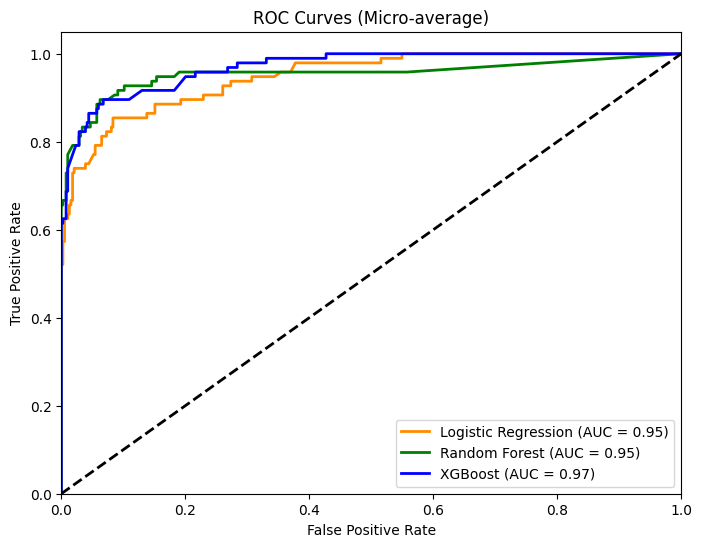

In [42]:
plot_roc_curves(models, models_names, X_test, y_test)